# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [46]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_USE_CUDA_DSA"] = '1'

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [47]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10( # 과제: Dataset을 MNIST에서 CIFAR10으로 변경해줍니다.
	root='./data',
	train=True,
	download=True,
	transform=transform
)

Files already downloaded and verified


Test Set 데이터 로드

In [48]:
testSet = torchvision.datasets.CIFAR10(
	root='./data',
	train=False,
	download=True,
	transform=transform
)

Files already downloaded and verified


MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

50000
torch.Size([3, 32, 32]) 6


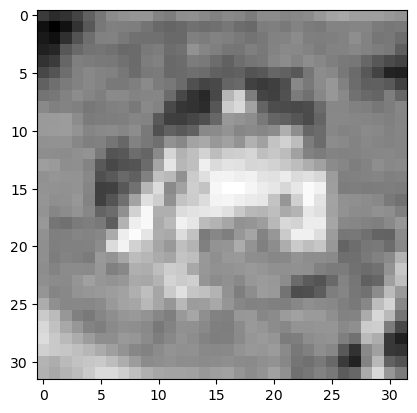

In [49]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1]) # 과제: CIFAR10의 입력 shape 확인
plt.imshow(trainset[0][0][0], cmap='gray')

Test Set 미리보기

10000
torch.Size([3, 32, 32]) 3


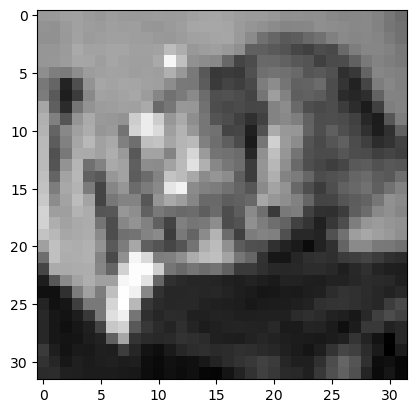

In [50]:
print(len(testSet))
print(testSet[0][0].shape, testSet[0][1]) # testSet[데이터 인덱스][0: 데이터, 1: 라벨]
plt.imshow(testSet[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [51]:
batch_size = 256 # 과제: 학습 인자는 n_epochs = 50, batch_size = 256로 설정합니다.

trainloader = torch.utils.data.DataLoader(
	trainset,
	batch_size=batch_size,
	shuffle=True
)

Test Data

In [52]:
testLoader = torch.utils.data.DataLoader(
	testSet,
	batch_size=batch_size,
	shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [53]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [54]:
from torch import nn

class Model(nn.Module): # nn.Modlue 상속
	def __init__(self, input_dim, n_dim):
		super().__init__()

		self.layer1 = nn.Linear(input_dim, n_dim)
		self.layer2 = nn.Linear(n_dim, n_dim)
		self.layer3 = nn.Linear(n_dim, 10)
		self.act = nn.LeakyReLU() # 과제:  Activation 함수를 nn.ReLU에서 nn.LeakyReLU로 변경해줍니다.

	def forward(self, x):
		x = torch.flatten(x, start_dim=1)
		x = self.act(self.layer1(x))
		x = self.act(self.layer2(x))
		x = self.act(self.layer3(x))
		return x

def accuracy(model, dataloader):
	with torch.no_grad():
		model.eval()
		cnt = 0
		acc = 0

		for data in dataloader:
			inputs, labels = data
			inputs, labels = inputs.to('cuda'), labels.to('cuda')

			preds = model(inputs)
			preds = torch.argmax(preds, dim=-1)

			cnt += labels.shape[0]
			acc += (labels == preds).sum().item()

		return acc / cnt

model = Model(32 * 32 * 3, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [55]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

In [56]:
from torch.optim import Adam

optimizerAdam = Adam(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [33]:
trainAccuracyList = []
testAccuracyList = []

# 손실함수 정의 (criterion ?)
lossFunction = nn.CrossEntropyLoss()

n_epochs = 50 # 과제: 학습 인자는 n_epochs = 50, batch_size = 256로 설정합니다.
print(batch_size)
for epoch in range(n_epochs):
	total_loss = 0.
	for data in trainloader:
		model.zero_grad()
		inputs, labels = data
		inputs, labels = inputs.to('cuda'), labels.to('cuda')

		preds = model(inputs)
		loss = lossFunction(preds, labels)
		#loss = (preds[:, 0] - labels).pow(2).mean() # MSE
		loss.backward()
		optimizer.step()

		total_loss += loss.item()
	print(f"Epoch {epoch:3d} | Loss: {total_loss}")
	trainAccuracyList.append(accuracy(model, trainloader))
	testAccuracyList.append(accuracy(model, testLoader))

256
Epoch   0 | Loss: 450.9860942363739
Epoch   1 | Loss: 450.329363822937
Epoch   2 | Loss: 449.6725215911865
Epoch   3 | Loss: 449.0836248397827
Epoch   4 | Loss: 448.5323233604431
Epoch   5 | Loss: 447.99605679512024
Epoch   6 | Loss: 447.4552073478699
Epoch   7 | Loss: 446.9284429550171
Epoch   8 | Loss: 446.3911099433899
Epoch   9 | Loss: 445.8498923778534
Epoch  10 | Loss: 445.3422589302063
Epoch  11 | Loss: 444.80692172050476
Epoch  12 | Loss: 443.825049161911
Epoch  13 | Loss: 442.77850437164307
Epoch  14 | Loss: 441.7710053920746
Epoch  15 | Loss: 440.83439326286316
Epoch  16 | Loss: 439.8805913925171
Epoch  17 | Loss: 438.6383652687073
Epoch  18 | Loss: 436.5205693244934
Epoch  19 | Loss: 434.6741771697998
Epoch  20 | Loss: 432.94018936157227
Epoch  21 | Loss: 431.179669380188
Epoch  22 | Loss: 429.47587966918945
Epoch  23 | Loss: 427.7905614376068
Epoch  24 | Loss: 426.1819648742676
Epoch  25 | Loss: 424.5838038921356
Epoch  26 | Loss: 422.9849314689636
Epoch  27 | Loss: 421

In [57]:
trainAdamAccuracyList = []
testAdamAccuracyList = []

for epoch in range(n_epochs):  #과제: 먼저 Adam optimizer을 사용하여 학습하는 코드를 구현합니다.
	total_loss = 0.
	model.train()
	for data in trainloader:
		model.zero_grad()
		inputs, labels = data
		inputs, labels = inputs.to('cuda'), labels.to('cuda')

		preds = model(inputs)
		loss = lossFunction(preds, labels)
		loss.backward()
		optimizerAdam.step()

		total_loss += loss.item()
	print(f"Epoch {epoch:3d} | Loss: {total_loss}")
	trainAdamAccuracyList.append(accuracy(model, trainloader))
	testAdamAccuracyList.append(accuracy(model, testLoader))

Epoch   0 | Loss: 434.00084710121155
Epoch   1 | Loss: 394.8875731229782
Epoch   2 | Loss: 370.8602102994919
Epoch   3 | Loss: 354.3015549182892
Epoch   4 | Loss: 341.58826184272766
Epoch   5 | Loss: 331.2310961484909
Epoch   6 | Loss: 324.15391993522644
Epoch   7 | Loss: 317.66203796863556
Epoch   8 | Loss: 312.04065918922424
Epoch   9 | Loss: 303.74563789367676
Epoch  10 | Loss: 298.7573503255844
Epoch  11 | Loss: 293.6272631883621
Epoch  12 | Loss: 287.19432866573334
Epoch  13 | Loss: 282.9554418325424
Epoch  14 | Loss: 279.1410037279129
Epoch  15 | Loss: 276.11671674251556
Epoch  16 | Loss: 271.6995143890381
Epoch  17 | Loss: 267.8010787963867
Epoch  18 | Loss: 265.0752663612366
Epoch  19 | Loss: 261.32709550857544
Epoch  20 | Loss: 257.37476086616516
Epoch  21 | Loss: 254.79219806194305
Epoch  22 | Loss: 251.62702906131744
Epoch  23 | Loss: 247.68663489818573
Epoch  24 | Loss: 243.64693009853363
Epoch  25 | Loss: 240.67668545246124
Epoch  26 | Loss: 239.50923109054565
Epoch  27 | 

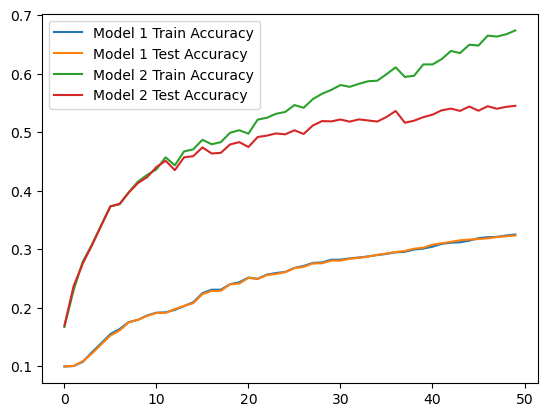

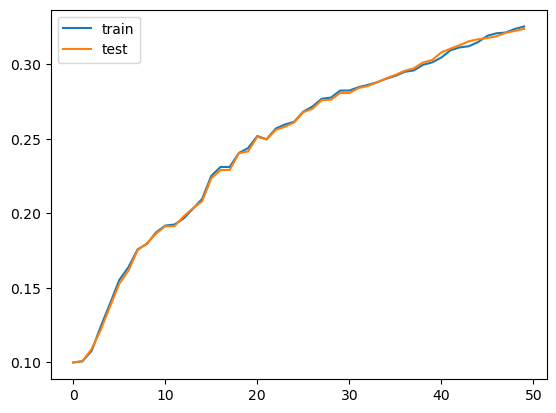

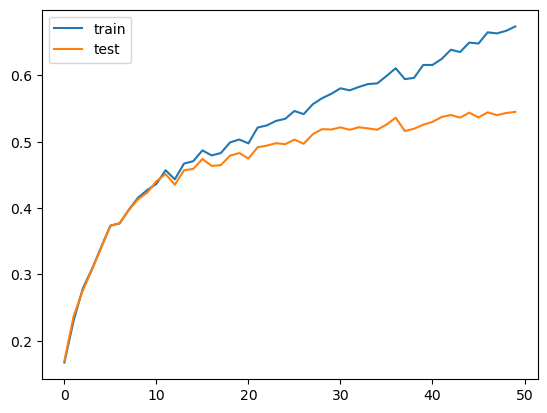

In [36]:
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
	x = np.arange(len(train_accs))

	plt.plot(x, train_accs, label=label1)
	plt.plot(x, test_accs, label=label2)
	plt.legend()
	plt.show()

def plotAccuracyTwo(trainAcc1, testAcc1, trainAcc2, testAcc2):
	x = np.arange(len(trainAcc1))

	plt.plot(x, trainAcc1, label="Model 1 Train Accuracy")
	plt.plot(x, testAcc1, label="Model 1 Test Accuracy")
	plt.plot(x, trainAcc2, label="Model 2 Train Accuracy")
	plt.plot(x, testAcc2, label="Model 2 Test Accuracy")
	plt.legend()
	plt.show()

plotAccuracyTwo(trainAccuracyList, testAccuracyList, trainAdamAccuracyList, testAdamAccuracyList)
plot_acc(trainAccuracyList, testAccuracyList) # 과제: (Plot 1) SGD와 Adam을 학습시킨 후 각각의 epoch에 대한 train 정확도를 plot합니다.
plot_acc(trainAdamAccuracyList, testAdamAccuracyList)

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [37]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[-10.1371, -12.3757, -10.6093,  -9.1390, -10.2214, -10.0316,  -7.9861,
         -10.6665, -13.4692, -13.6385]], device='cuda:0',
       grad_fn=<LeakyReluBackward0>)
6


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

In [39]:
class ModelSigmoid(nn.Module): # 과제: Activation 함수가 nn.Sigmoid인 class를 새로 정의합니다.
	def __init__(self, input_dim, n_dim):
		super().__init__()

		self.layer1 = nn.Linear(input_dim, n_dim)
		self.layer2 = nn.Linear(n_dim, n_dim)
		self.layer3 = nn.Linear(n_dim, 10)
		self.act = nn.Sigmoid()

	def forward(self, x):
		x = torch.flatten(x, start_dim=1)
		x = self.act(self.layer1(x))
		x = self.act(self.layer2(x))
		x = self.act(self.layer3(x))
		return x

modelSigmoid = ModelSigmoid(32 * 32 * 3, 1024)
modelSigmoid = modelSigmoid.to('cuda')

optimizerAdam = Adam(modelSigmoid.parameters(), lr=lr)

trainSigmoidAccuracyList = []
testSigmoidAccuracyList = []

for epoch in range(n_epochs):
	total_loss = 0.
	for data in trainloader:
		modelSigmoid.zero_grad()
		inputs, labels = data
		inputs, labels = inputs.to('cuda'), labels.to('cuda')

		preds = modelSigmoid(inputs)
		loss = lossFunction(preds, labels)
		loss.backward()
		optimizerAdam.step()

		total_loss += loss.item()
	print(f"Epoch {epoch:3d} | Loss: {total_loss}")
	trainSigmoidAccuracyList.append(accuracy(modelSigmoid, trainloader))
	testSigmoidAccuracyList.append(accuracy(modelSigmoid, testLoader))

Epoch   0 | Loss: 411.6378208398819
Epoch   1 | Loss: 393.9763705730438
Epoch   2 | Loss: 387.4422491788864
Epoch   3 | Loss: 384.0856041908264
Epoch   4 | Loss: 381.44155859947205
Epoch   5 | Loss: 379.3883900642395
Epoch   6 | Loss: 378.2175837755203
Epoch   7 | Loss: 376.1644674539566
Epoch   8 | Loss: 375.22554659843445
Epoch   9 | Loss: 373.20065343379974
Epoch  10 | Loss: 372.20846796035767
Epoch  11 | Loss: 371.53050458431244
Epoch  12 | Loss: 370.6126446723938
Epoch  13 | Loss: 369.08683025836945
Epoch  14 | Loss: 367.74171936511993
Epoch  15 | Loss: 367.14857709407806
Epoch  16 | Loss: 366.9139473438263
Epoch  17 | Loss: 366.13162910938263
Epoch  18 | Loss: 365.47871017456055
Epoch  19 | Loss: 364.5946835279465
Epoch  20 | Loss: 364.68759882450104
Epoch  21 | Loss: 363.72175443172455
Epoch  22 | Loss: 362.80636501312256
Epoch  23 | Loss: 362.4465708732605
Epoch  24 | Loss: 361.95240890979767
Epoch  25 | Loss: 361.1679437160492
Epoch  26 | Loss: 361.21932792663574
Epoch  27 | L

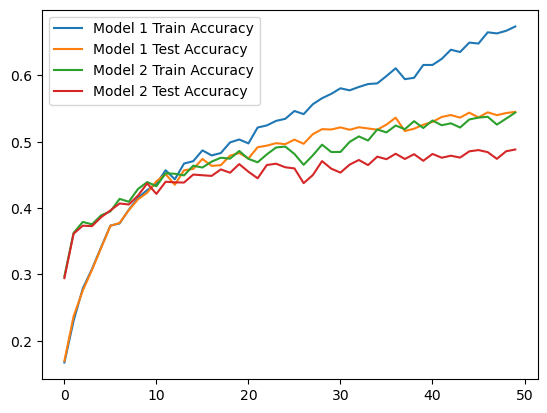

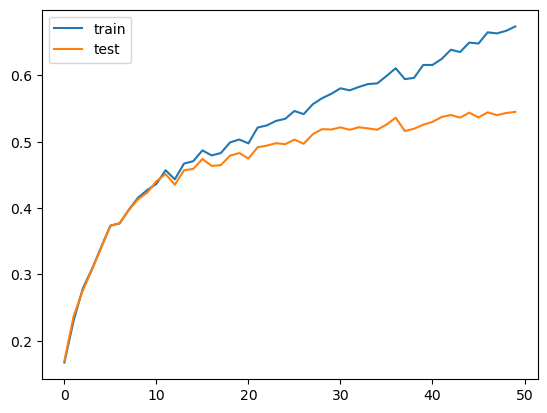

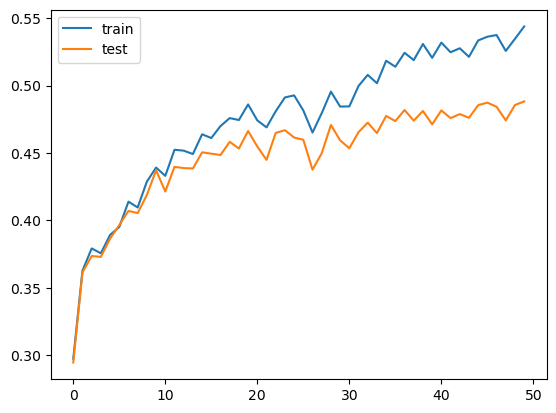

In [40]:
# 과제: (Plot 2) Adam optimizer를 가지고 sigmoid와 leaky ReLU 모델들을 학습한 후, epoch에 따른 train 정확도를 비교합니다.

plotAccuracyTwo(trainAdamAccuracyList, testAdamAccuracyList, trainSigmoidAccuracyList, testSigmoidAccuracyList)
plot_acc(trainAdamAccuracyList, testAdamAccuracyList)
plot_acc(trainSigmoidAccuracyList, testSigmoidAccuracyList)

In [41]:
# 과제: PyTorch dropout을 leaky ReLU를 사용하는 MLP의 모든 layer에 적용한 class를 새로 정의합니다. Dropout 확률은 0.1로 설정합니다.

class ModelDropout(nn.Module): # nn.Modlue 상속
	def __init__(self, input_dim, n_dim, dropoutRate = 0.1):
		super().__init__()

		self.layer1 = nn.Linear(input_dim, n_dim)
		self.layer2 = nn.Linear(n_dim, n_dim)
		self.layer3 = nn.Linear(n_dim, 10)
		self.act = nn.LeakyReLU()
		self.dropout = nn.Dropout(dropoutRate)

	def forward(self, x):
		x = torch.flatten(x, start_dim=1)
		x = self.act(self.layer1(x))
		x = self.dropout(x)   
		x = self.act(self.layer2(x))
		x = self.dropout(x)
		x = self.act(self.layer3(x))
		x = self.dropout(x)
		return x
	

In [42]:
modelDropout = ModelDropout(32 * 32 * 3, 1024)
modelDropout = modelDropout.to('cuda')

optimizerAdam = Adam(modelDropout.parameters(), lr=lr)

trainDropoutAccuracyList = []
testDropoutAccuracyList = []

for epoch in range(n_epochs):
	total_loss = 0.
	modelDropout.train()
	for data in trainloader:
		modelDropout.zero_grad()
		inputs, labels = data
		inputs, labels = inputs.to('cuda'), labels.to('cuda')

		preds = modelDropout(inputs)
		loss = lossFunction(preds, labels)
		loss.backward()
		optimizerAdam.step()

		total_loss += loss.item()
	print(f"Epoch {epoch:3d} | Loss: {total_loss}")
	trainDropoutAccuracyList.append(accuracy(modelDropout, trainloader))
	testDropoutAccuracyList.append(accuracy(modelDropout, testLoader))

Epoch   0 | Loss: 441.80675649642944
Epoch   1 | Loss: 417.09881138801575
Epoch   2 | Loss: 410.3476233482361
Epoch   3 | Loss: 398.30585980415344
Epoch   4 | Loss: 390.54862928390503
Epoch   5 | Loss: 384.978435754776
Epoch   6 | Loss: 381.91528403759
Epoch   7 | Loss: 377.1881254911423
Epoch   8 | Loss: 372.8138527870178
Epoch   9 | Loss: 369.6829344034195
Epoch  10 | Loss: 364.4663220643997
Epoch  11 | Loss: 363.6402292251587
Epoch  12 | Loss: 360.7067358493805
Epoch  13 | Loss: 357.9720801115036
Epoch  14 | Loss: 356.87400925159454
Epoch  15 | Loss: 353.9099260568619
Epoch  16 | Loss: 351.28566312789917
Epoch  17 | Loss: 351.1340985298157
Epoch  18 | Loss: 347.1117627620697
Epoch  19 | Loss: 344.76525139808655
Epoch  20 | Loss: 344.2835502624512
Epoch  21 | Loss: 341.3107445240021
Epoch  22 | Loss: 339.8079615831375
Epoch  23 | Loss: 337.0870201587677
Epoch  24 | Loss: 336.9347816705704
Epoch  25 | Loss: 333.2731500864029
Epoch  26 | Loss: 334.3860445022583
Epoch  27 | Loss: 331.64

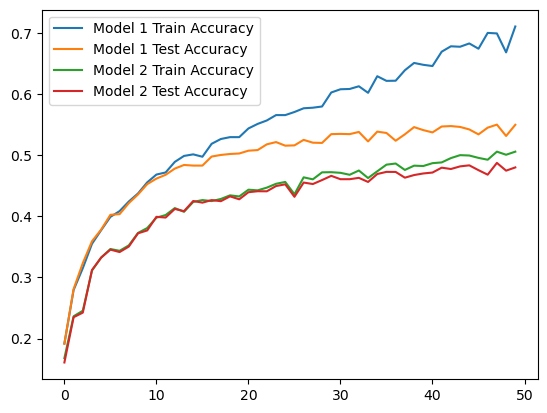

In [58]:
#과제: (Plot 3) Adam optimizer를 가지고 dropout을 적용한 모델을 학습한 후, epoch에 따른 train과 test 정확도를 비교합니다.

plotAccuracyTwo(trainAdamAccuracyList, testAdamAccuracyList, trainDropoutAccuracyList, testDropoutAccuracyList)
